# Modelos Geocéntricos
Agrego aquí que amé la frase "Linear regression is the geocentric model of applied statistics".

In [1]:
%load_ext rpy2.ipython

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


## 4.1

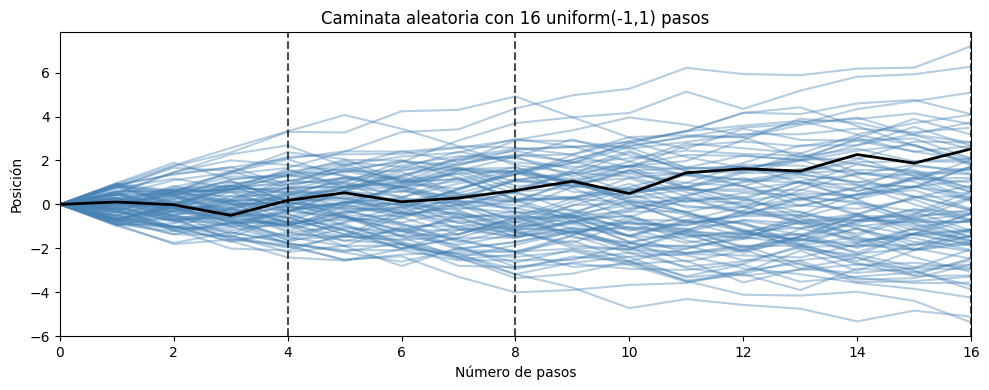

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_walks = 100
steps = 16

raw = np.random.uniform(-1, 1, size=(n_walks, steps))

walks = np.hstack([
    np.zeros((n_walks, 1)), # Todos inician en cero
    np.cumsum(raw, axis=1)  # luego vamos sumando en forma cumulativa por cada paso.
])

fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos las trayectorias
for i in range(n_walks-1): # excepto la última
    ax.plot(range(steps + 1), walks[i], alpha=0.4, color="steelblue")

ax.plot(range(steps + 1), walks[-1],  linewidth=2, color="black")

# dashed vertical lines at 4, 8, 16 steps
for v in [4, 8, 16]:
    ax.axvline(v, ls='--', color='black', alpha=0.7)

ax.set_xlabel("Número de pasos")
ax.set_ylabel("Posición")
ax.set_xlim(0, steps)
ax.set_title("Caminata aleatoria con 16 uniform(-1,1) pasos")

plt.tight_layout()
plt.show()


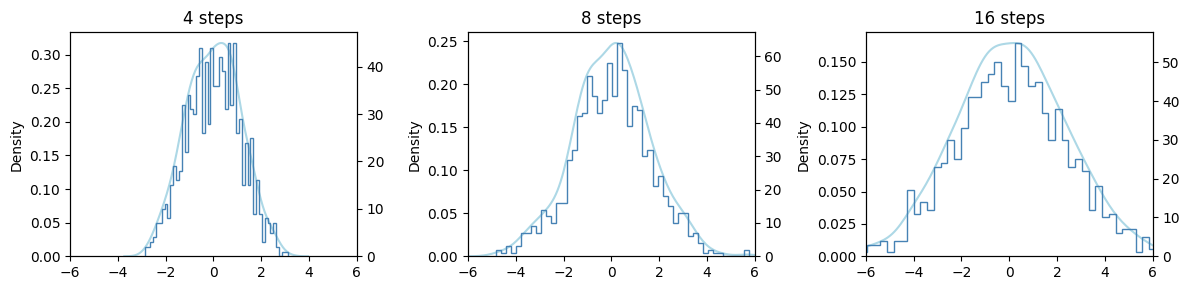

In [3]:

def random_walks(steps):
    return (
        np.random
        .uniform(
            -1, 1,
            size=(1000, steps),
        ).sum(axis=1)
    )

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, steps in zip(axes, (4, 8, 16)):
    pos = random_walks(steps)

   
    sns.kdeplot(pos, ax=ax, color='lightblue')
    ax.set_title(f"{steps} steps")
    ax.set_xlim(-6, 6)
    
    ax2 = ax.twinx()
    ax2.hist(pos, bins=50, histtype='step', color='steelblue')
plt.tight_layout()
plt.show()


## Loading data from rethinking directly

In [4]:
%%R -o df
library(rethinking)

data(Howell1)
df = Howell1


Cargando paquete requerido: cmdstanr
This is cmdstanr version 0.9.0
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
Cargando paquete requerido: posterior
This is posterior version 1.6.1

Adjuntando el paquete: 'posterior'

The following objects are masked from 'package:stats':

    mad, sd, var

The following objects are masked from 'package:base':

    %in%, match

Cargando paquete requerido: parallel
rethinking (Version 2.42)

Adjuntando el paquete: 'rethinking'

The following object is masked from 'package:stats':

    rstudent



In [5]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np


df: pd.DataFrame

## 4.20

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


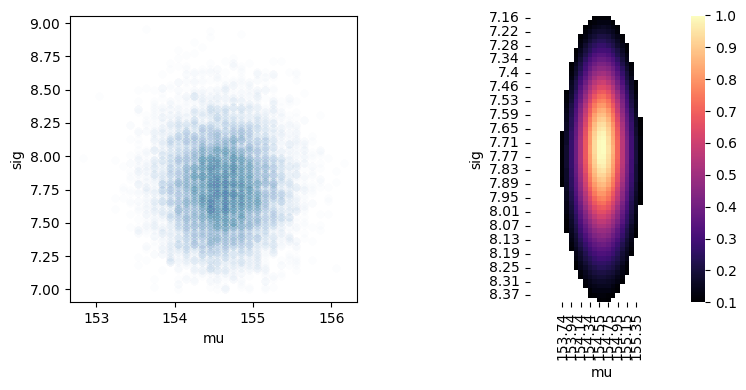

In [25]:
d2 = df[df.age >=18]
hi = d2.height.values
# hi = df.height.values

# Define grid axes
mu_list = np.linspace(150, 160, 100)
sigma_list = np.linspace(7, 9, 100)

# Create Cartesian product
post = pd.DataFrame({
    'mu': np.tile(mu_list, len(sigma_list)),
    'sig': np.repeat(sigma_list, len(mu_list))
})

Lf = stats.norm.logpdf
post['LL'] = post.apply(
  lambda r: Lf(hi, r['mu'], r['sig']).sum(),
  axis=1
)

post['lmu'] = Lf(post.mu, 178, 20)
post['lsig'] = stats.uniform.logpdf(
  post.sig, 0, 50
)
post['prod'] = (
  post.LL + post.lmu + post.lsig
)

post['prob'] = np.exp(
  post['prod'] - max(post['prod'])
)

samples = post.sample(
  weights='prob',
  n=int(1e4),
  replace=True
)

import matplotlib.pyplot as plt
import seaborn as sns

_, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 4), )
sns.scatterplot(samples, x='mu', y='sig', alpha=0.01, ax=ax1)
ax1.set_box_aspect(1)
piv = (
    post.query('prob >= 0.1')
    .round(2)
    .pivot(index='sig', columns='mu', values='prob')
)

sns.heatmap(piv, ax=ax2, cmap='magma', square=True, antialiased=True)
ax2.set_box_aspect(2)
plt.tight_layout()
plt.show()

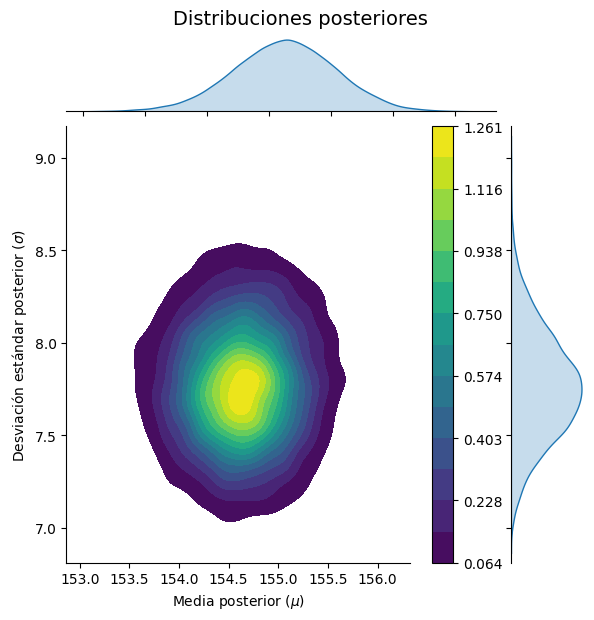

In [7]:
g = sns.JointGrid(
    data=samples,
    x='mu', 
    y='sig',
    height=6,
)

g.plot_joint(
    sns.kdeplot, 
    fill=True, 
    cbar=True,
    cmap='viridis', 
    levels=15,
)

g.plot_marginals(sns.kdeplot, fill=True)

g.ax_joint.set_xlabel(r'Media posterior ($\mu$)')
g.ax_joint.set_ylabel(r'Desviación estándar posterior ($\sigma$)')
g.figure.suptitle('Distribuciones posteriores', y=1.02, fontsize=14)

plt.show()

## Regression simulation

$W_i = \beta H_i + U_i$

$U_i \sim Normal(0, \sigma)$ 

$H_i \sim Uniform(130, 170)$

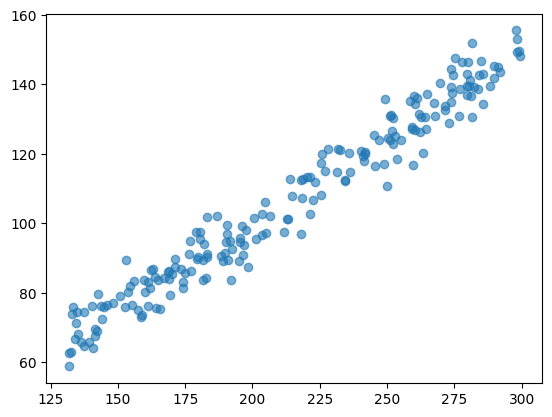

In [8]:
def sim_weight(H, b, sd):
    U = stats.norm.rvs(0, sd, size=len(H))
    W = b * H + U
    return W

H = stats.uniform.rvs(130, 170, size=200)
W = sim_weight(H, 0.5, 5)
plt.scatter(H, W, alpha=0.6)

In [9]:
import pymc as pm
import arviz as az
b = 0.5
sd = 5
with pm.Model() as model:
    Ui = pm.Normal('Ui', 0, sd)
    Hi = pm.Uniform('Hi', 130, 170)
    #beta = pm.Normal('beta', 0, 2)
    Wi = pm.Deterministic('Wi', b*Hi+Ui)
    idata = pm.sample(nuts_sampler='blackjax', progressbar=0)

pm.summary(idata)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ui,0.102,5.109,-8.947,9.995,0.084,0.076,3702.0,2756.0,1.0
Hi,149.801,11.595,130.569,168.214,0.204,0.122,2874.0,2350.0,1.0
Wi,75.002,7.540,60.763,88.279,0.130,0.107,3365.0,2454.0,1.0


array([[<Axes: >, None],
       [<Axes: xlabel='Hi', ylabel='Wi'>, <Axes: >]], dtype=object)

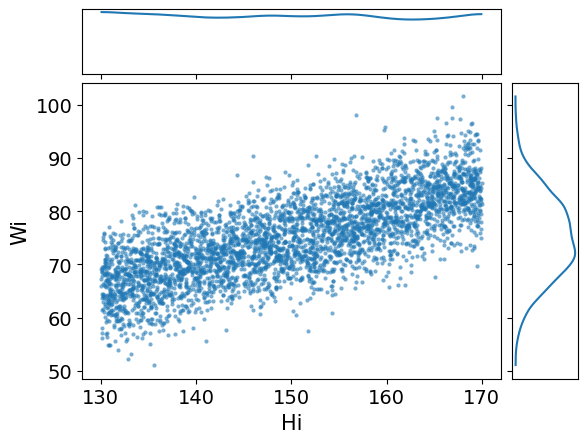

In [10]:
az.plot_pair(
    idata, 
    var_names=[ 'Hi', 'Wi',], 
    scatter_kwargs={'alpha': 0.6}, 
    marginals=True,
)


## Estimator
$E(W_i|H_i)= \alpha + \beta H_i$

Alfa es el intercepto, beta la pendiente.
El objetivo es el valor esperado del peso condicionado por la altura.

### Distribución posterior:

$$
Pr(\alpha, \beta, \sigma | H_i, W_i) = \frac{Pr(W_i|H_i, \alpha, \beta, \sigma)Pr(\alpha, \beta, \sigma)}{Z}
$$

A la izquierda la distribución posterior para la línea de la regresión, condicionado al peso y talla.
Z es la constante de normalización.

### Modelo:

$W_i \sim Normal(\mu, \sigma)$

$\mu_i = \alpha + \beta H_i$


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,544.0,138.263596,27.602448,53.975000,125.095000,148.590000,157.480000,179.070000
weight,544.0,35.610618,14.719178,4.252425,22.007717,40.057844,47.209005,62.992589
age,544.0,29.344393,20.746888,0.000000,12.000000,27.000000,43.000000,88.000000
male,544.0,0.472426,0.499699,0.000000,0.000000,0.000000,1.000000,1.000000


### Quap
#### R

In [12]:
%%R
W <- df$weight
H <- df$height

m3.1 <- quap(
    alist(
        W ~ dnorm(mu, sigma),
        mu <- a + b*H,
        a ~ dnorm(0, 10),
        b ~ dunif(0, 1),
        sigma ~ dunif(0, 10)
    ), data=list(W=W, H=H)
)
precis(m3.1)

        mean   sd   5.5%  94.5%
a     -33.36 1.09 -35.09 -31.62
b       0.50 0.01   0.49   0.51
sigma   4.98 0.15   4.74   5.23


#### Python

In [14]:
with pm.Model() as model:
    a = pm.Normal('a', 0, 10)
    b = pm.Uniform('b', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', a + b*df['height'])
    W = pm.Normal('W', mu, sigma, observed=df['weight'])
    mp = pm.find_MAP(progressbar=0)
    hess = pm.find_hessian(mp, negate_output=False)
    # si negate output no es True, se genera una advertencia
    covariance_matrix = np.linalg.inv(-hess)
    stds = np.sqrt(np.diag(covariance_matrix))

print()
result = pd.DataFrame(columns=['mean', 'std', '5.5%', '94.5%'])
vars = ['a', 'b', 'sigma']

for i, var in enumerate(vars):
    # A diferencia del capítulo 2
    # tenemos ahora 3 variables clave por lo que tenemos que buscarlas
    # de forma independiente
    map_point = float(mp[var])
    sd = stds[i]
    lo, hi = stats.norm.ppf([0.055, 0.945], loc=map_point, scale=sd)
    result.loc[var] = map_point, sd, lo, hi
result.round(2)

,mean,std,5.5%,94.5%
a,-33.36,1.09,-35.09,-31.62
b,0.50,0.03,0.45,0.55
sigma,4.98,0.06,4.89,5.08


## Predicción lineal
**Modelo de la regresión**:
- $h_i \sim Normal(\mu_i, \sigma)$ # Verosimilitud
- $\mu_i = \alpha + \beta (x_i - \bar{x})$ # Modelo lineal
- $\alpha \sim Normal(178, 20)$ # prior intercepto
- $\beta \sim Normal(0, 10)$ # prior coeficiente
- $\sigma \sim Uniform(0, 50)$ # prior sigma


In [28]:
%%R -o d2

data(Howell1); d <- Howell1; d2 <- d[ d$age >= 18 , ]
# define the average weight, x-bar
xbar <- mean(d2$weight)

m4.3b <- quap(
    alist(
    height ~ dnorm( mu , sigma ) ,
    mu <- a + exp(log_b)*( weight - xbar ),
    a ~ dnorm( 178 , 20 ) ,
    log_b ~ dnorm( 0 , 1 ) ,
    sigma ~ dunif( 0 , 50 )
    ) , data=d2 )
precis(m4.3b)

        mean   sd   5.5%  94.5%
a     154.60 0.27 154.17 155.03
log_b  -0.10 0.05  -0.17  -0.03
sigma   5.07 0.19   4.77   5.38


### Prior predictive

In [58]:
d2: pd.DataFrame

Sampling: [a, beta, sigma]
Sampling: [Height_pred, a, log_b, sigma]


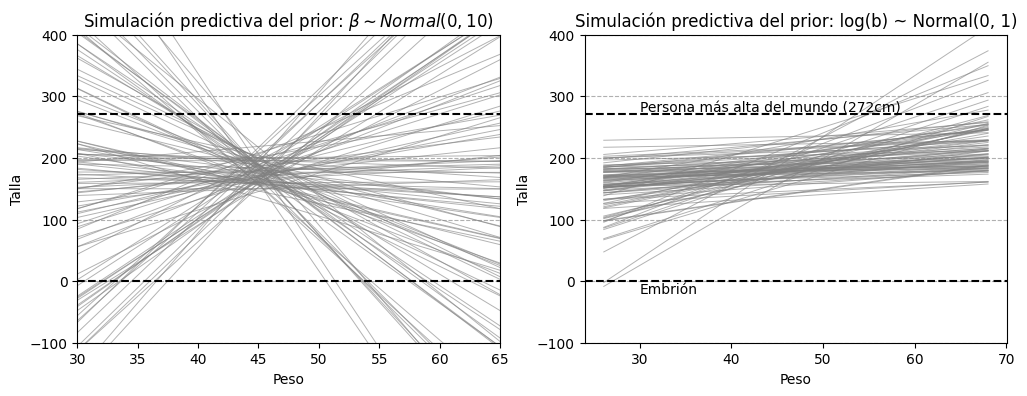

In [57]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) # figura
xbar = d2.weight.mean()
weight_seq = np.linspace(d2['weight'].min() - 5, d2['weight'].max() + 5, 50)

# el primer modelo consider b~norm(0, 10)
with pm.Model() as model_bad_prior:
    # Priors
    a = pm.Normal('a', 178, 20)
    # 💥 Prior Insensible: beta ~ Normal(0, 10)
    beta = pm.Normal('beta', 0, 10) 
    sigma = pm.Uniform('sigma', 0, 50)
    
    # Modelo lineal: mu
    mu_bad = pm.Deterministic('mu_bad', a + beta * (d2['weight'] - xbar))
    
    prior_predictive_bad = pm.sample_prior_predictive(samples=100)

# Obtener las muestras de los parámetros del prior
prior_a_bad = prior_predictive_bad.prior['a'].values.ravel()
prior_beta_bad = prior_predictive_bad.prior['beta'].values.ravel()

# Calcular mu para cada muestra de prior (Figura A)
prior_mus_bad = np.array([
    a_val + beta_val * (weight_seq - xbar)
    for a_val, beta_val
    in zip(prior_a_bad, prior_beta_bad)
])


# Trazar cada línea de regresión
for i in range(100):
    ax1.plot(weight_seq, prior_mus_bad[i, :], color='gray', alpha=0.6, linewidth=0.7)

# Configuración del gráfico A
ax1.axhline(0, color='black', linestyle='--') 
ax1.axhline(272, color='black', linestyle='--') 

ax1.set_xlabel('Peso')
ax1.set_ylabel('Talla')
ax1.set_title(r'Simulación predictiva del prior: $\beta \sim Normal(0, 10)$')
ax1.set_xlim(30, 65)
ax1.set_ylim(-100, 400) 
ax1.grid(axis='y', linestyle='--')

# el segundo modelo cnsidera log(b)~dnorm(0,1)
with pm.Model() as model:
    # Priors
    a = pm.Normal('a', 178, 20)
    log_b = pm.Normal('log_b', 0, 1)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + pm.math.exp(log_b) * (d2['weight'] - xbar))
    Height_pred = pm.Normal('Height_pred', mu, sigma, shape=len(d2)) 
    
    prior_predictive = pm.sample_prior_predictive(samples=100)



prior_a = prior_predictive.prior['a'].values.ravel()
prior_log_b = prior_predictive.prior['log_b'].values.ravel()

prior_mus = np.array([
    a_val + np.exp(log_b_val) * (weight_seq - xbar)
    for a_val, log_b_val
    in zip(prior_a, prior_log_b)
])


# Trazar cada línea de regresión de la simulación del prior
for i in range(100): # Trazar 100 líneas (una por sample)
    ax2.plot(weight_seq, prior_mus[i, :], color='gray', alpha=0.6, linewidth=0.7)

# Configuración del gráfico
ax2.axhline(0, color='black', linestyle='--') # Línea de referencia en 0 (Embryo)
ax2.text(30, -20, 'Embrión')
ax2.axhline(272, color='black', linestyle='--') # Línea de referencia en 272 (Tallest person)
ax2.text(30, 275, 'Persona más alta del mundo (272cm)')

ax2.set_xlabel('Peso')
ax2.set_ylabel('Talla')
ax2.set_title('Simulación predictiva del prior: log(b) ~ Normal(0, 1)')
ax2.set_ylim(-100, 400) # Para tener la misma forma que el libro
ax2.grid(axis='y', linestyle='--')
plt.show()



### Modelo completo aproximación cuadrática

In [ ]:

with pm.Model() as model:
    a = pm.Normal('a', 178, 20)
    log_b = pm.Normal('log_b', 0, 1)
    sigma = pm.Uniform('sigma', 0, 50)
    
    mu = pm.Deterministic('mu', a + pm.math.exp(log_b) * (d2['weight']-d2['weight'].mean()))

    Height_obs = pm.Normal('Height_obs', mu, sigma, observed=d2['height'])
    
    mp = pm.find_MAP(progressbar=0)
    hess = pm.find_hessian(mp, negate_output=False)
    covariance_matrix = np.linalg.inv(-hess)
    stds = np.sqrt(np.diag(covariance_matrix))


result = pd.DataFrame(columns=['mean', 'std', '5.5%', '94.5%'])
vars = ['a', 'log_b', 'sigma']

map_results = {}
for i, var in enumerate(vars):
    map_point = float(mp[var])
    sd = stds[i]
    lo, hi = stats.norm.ppf([0.055, 0.945], loc=map_point, scale=sd)
    result.loc[var] = map_point, sd, lo, hi

result.round(2)

,mean,std,5.5%,94.5%
a,154.60,0.27,154.17,155.03
log_b,-0.10,0.05,-0.17,-0.03
sigma,5.07,0.04,5.00,5.14


#### Modelo MCMC

In [67]:

with pm.Model() as model:
    a = pm.Normal('a', 178, 20)
    log_b = pm.Normal('log_b', 0, 1)
    sigma = pm.Uniform('sigma', 0, 10)
    mu = pm.Deterministic('mu', a + pm.math.exp(log_b)*(d2['height']-d2['height'].mean()))
    W = pm.Normal('W', mu, sigma, observed=d2['weight'])
    idata = pm.sample(nuts_sampler='blackjax', progressbar=0)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, progressbar=0)
    prior_predictive = pm.sample_prior_predictive(samples=500, random_seed=42)
    idata.extend(prior_predictive)

az.summary(idata, var_names=['a', 'log_b', 'sigma'])

Sampling: [W]
Sampling: [W, a, log_b, sigma]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,45.004,0.224,44.597,45.419,0.004,0.003,4013.0,2747.0,1.0
log_b,-0.465,0.045,-0.549,-0.377,0.001,0.001,3420.0,2497.0,1.0
sigma,4.255,0.166,3.948,4.561,0.003,0.003,3869.0,2854.0,1.0


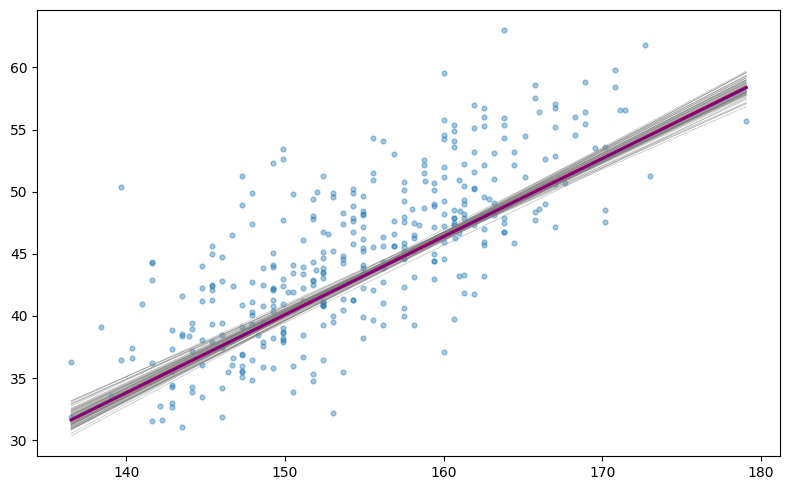

In [69]:
post = idata.posterior
a = post["a"].stack(s=("chain","draw")).values
b = post["log_b"].stack(s=("chain","draw")).values

x = np.linspace(d2.height.min(), d2.height.max(), 100)
idx = np.random.choice(len(a), 80, replace=False)

plt.figure(figsize=(8,5))
plt.scatter(d2.height, d2.weight, s=12, alpha=0.4)

for i in idx:
    plt.plot(x, a[i] + np.exp(b[i])*(x-x.mean()), color="gray", alpha=0.5, linewidth=0.5)

plt.plot(x, np.median(a) + np.exp(np.median(b)) * (x-x.mean()), color="red", lw=2)
plt.plot(x, np.mean(a) + np.exp(np.mean(b)) * (x-x.mean()), color="purple", lw=2)

plt.tight_layout()
plt.show()

<Axes: xlabel='W'>

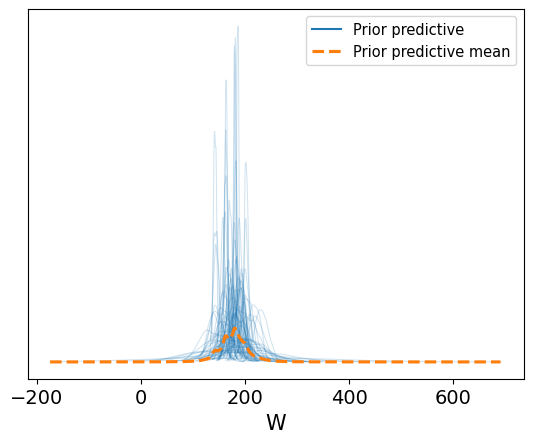

In [70]:
az.plot_ppc(
    idata,
    group="prior", 
    num_pp_samples=100,
    random_seed=42
)

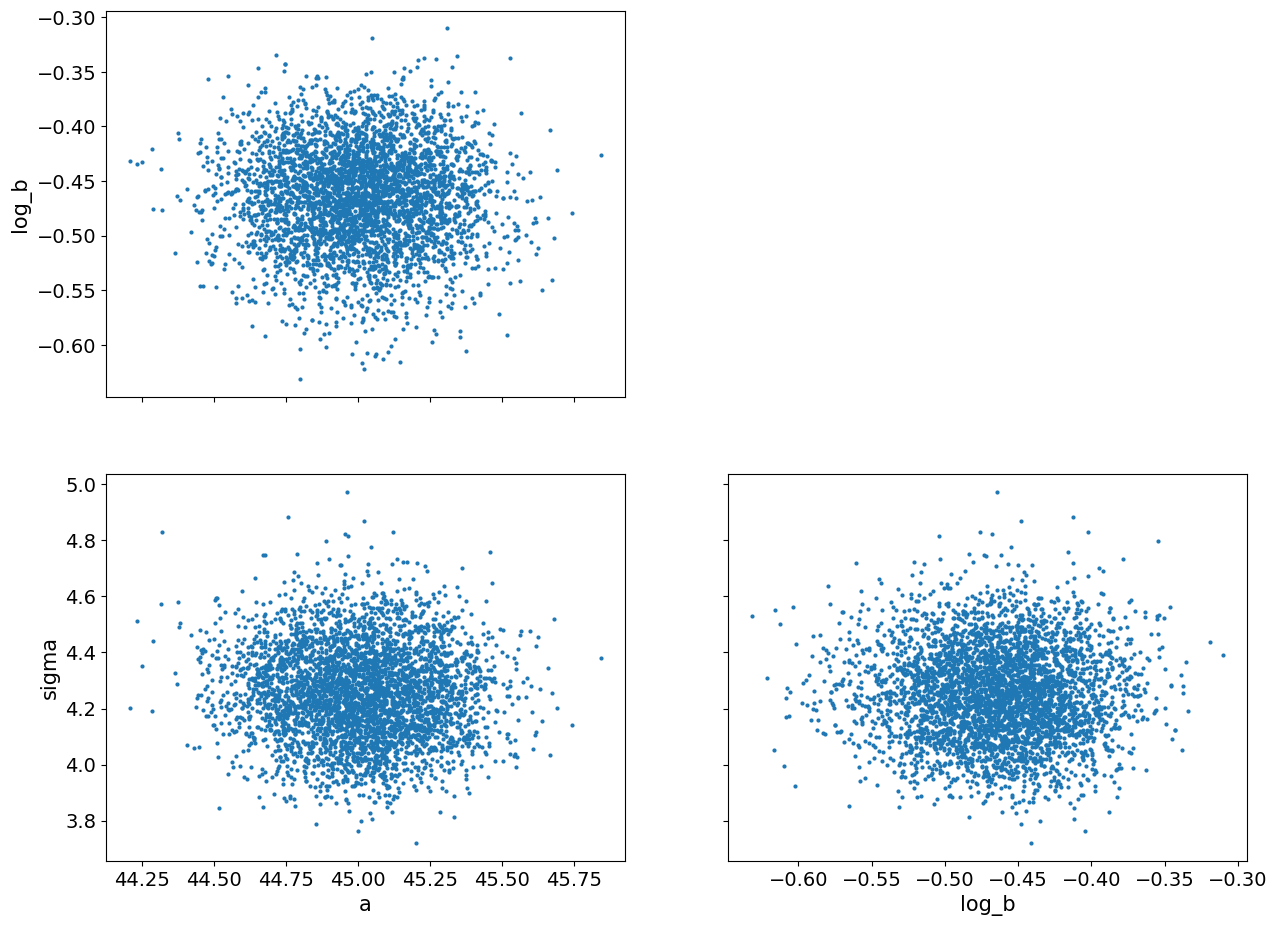

In [71]:
az.plot_pair(idata, var_names=['a', 'log_b', 'sigma']);

<Axes: xlabel='W'>

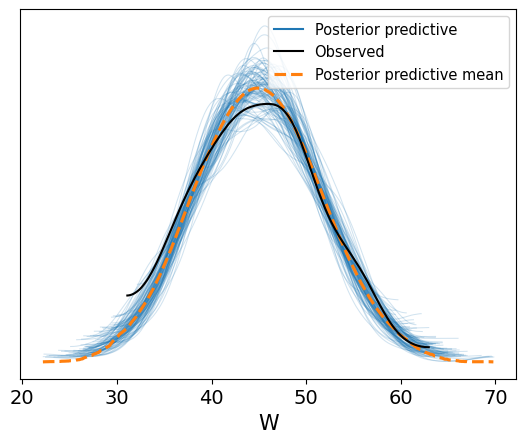

In [72]:
az.plot_ppc(idata, num_pp_samples=100,)

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

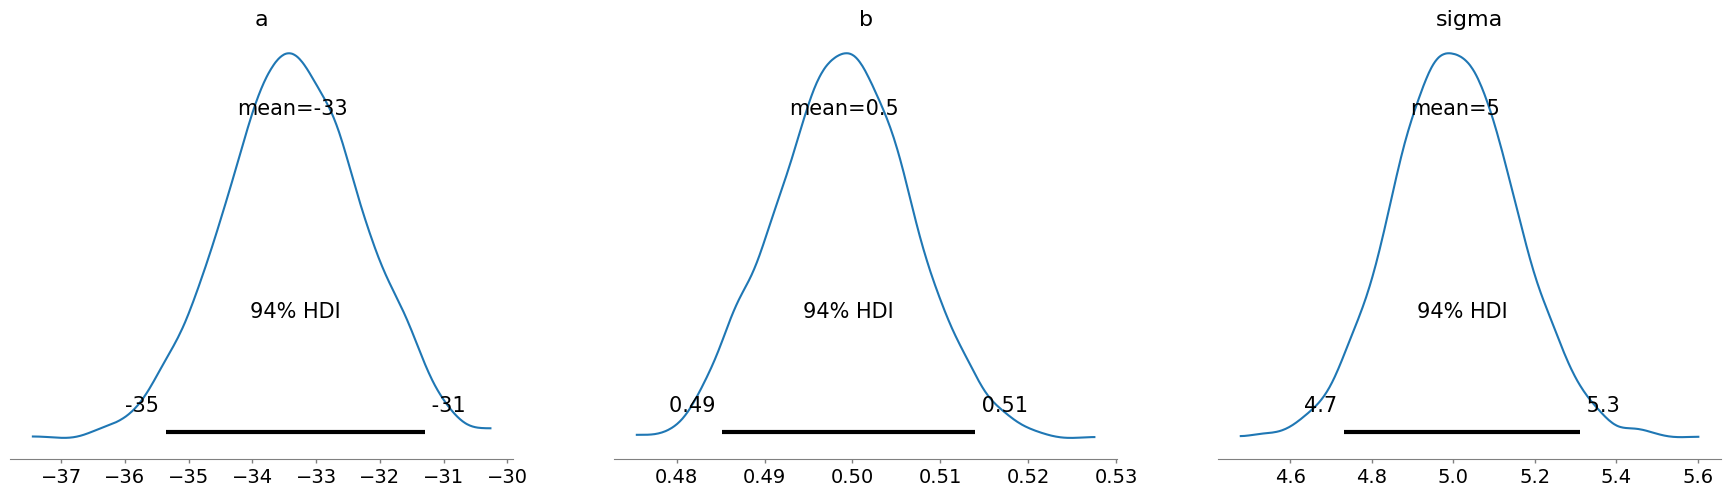

In [23]:
pm.plot_posterior(idata, var_names=['a', 'b', 'sigma'])

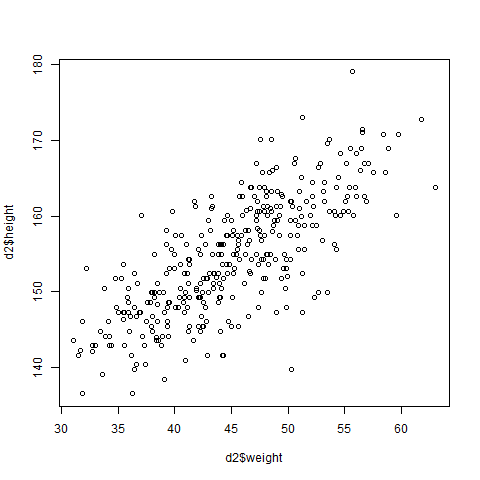

In [26]:
%%R
library(rethinking)
data(Howell1); d <- Howell1; d2 <- d[ d$age >= 18 , ]
plot( d2$height ~ d2$weight )